# Q1 Gillespie's Direct Algorithm and Stochastic Hallmarks

Investigate
1. Variability
2. Negative co-variances
3. Increased transients
4. Stochastic resonance
5. Extinctions

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from ndlib.models.CompositeModel import CompositeModel
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq
import scipy.stats as stats
from random import random
from glob import glob
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs
# plt.rcParams.update({ "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": " Computer Modern Roman"
# })

\begin{align}
\frac{dS}{dt} &= \mu -\beta SI - \mu S, \\
\frac{dI}{dt} &= \beta SI - \gamma I- I(\mu + \rho), \\
\frac{dR}{dt} &= \gamma I- \mu R. 
\end{align}

In [44]:
beta_df = pd.read_csv("data/finalbeta.csv")
gamma_df = pd.read_csv("data/finalgamma.csv")
mu_df = pd.read_csv("data/finalmu.csv")
N_df = pd.read_csv("data/finalN.csv")
gamma_N_df = pd.read_csv("data/finalgamma_N.csv")

# !!THIS WILL DOWNLOAD ABOUT 500MB OF DATA, THIS IS HERE IN CASE SOMEONE WANTS TO RUN THE CODE THEMSELVES. FETCHING AND READING IN THE DATA SHOULD NOT TAKE MORE THAN ABOUT 3 MINUTES!!

# beta_df = pd.read_csv("https://osf.io/download/32acs/")
# gamma_df = pd.read_csv("https://osf.io/download/z7y2c/")
# mu_df = pd.read_csv("https://osf.io/download/y75gx/")
# N_df = pd.read_csv("https://osf.io/download/anqw7/")
# gamma_N_df = pd.read_csv("https://osf.io/download/47ruc/")


In [4]:
def determinsteSIR(previousState, t, beta, gamma, birth_rate):
    state = np.empty(3)
    X, Y, Z = previousState
    state[0] = birth_rate - X * birth_rate - X * Y * beta
    state[1] = X * Y * beta - Y * birth_rate - Y * gamma
    state[2] = Y * gamma - Z * birth_rate
    return state


def return_Solved(beta, gamma, mu, N, steps):
    XYZ = [1, 1 / N, 0]
    t = np.linspace(0, 365, steps)

    solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, mu))
    return solved


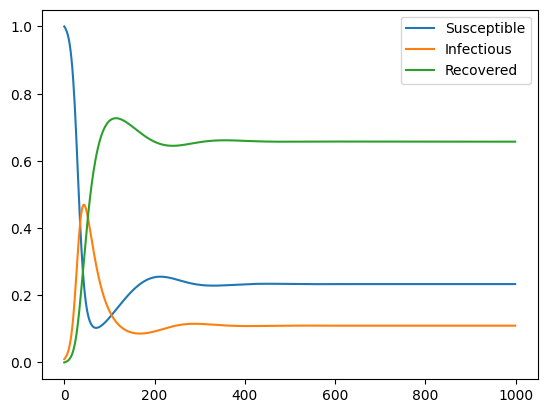

In [4]:
XYZ = [1, 0.01, 0]
t = np.linspace(0, 365, 1000)
beta = 1/2
gamma = 1/10
mu = 1 / 60

solved = odeint(determinsteSIR, XYZ, t, (beta, gamma, mu))
plt.plot(solved[:, 0], label="Susceptible")
plt.plot(solved[:, 1], label="Infectious")
plt.plot(solved[:, 2], label="Recovered")
plt.legend(loc="best")

In [7]:
def stoch_sir(XYZ, N, tend, beta, gamma, mu):
    # Columns: SIR, Rows: Events [infect, recovery, birth, death S, death I, death R]
    change_matrix = np.array(
        [[-1, 1, 0],
         [0, -1, 1],
         [1, 0, 0],
         [-1, 0, 0],
         [0, -1, 0],
         [0, 0, -1]
         ])
    current_t = 0
    ts = 0.1
    T = [0]
    S = [XYZ[0]]
    I = [XYZ[1]]
    R = [XYZ[2]]

    while T[current_t] < tend:
        T.append(T[-1] + ts)
        S.append(XYZ[0])
        I.append(XYZ[1])
        R.append(XYZ[2])

        event_rates = ([(beta * XYZ[0] * XYZ[1]) / N, gamma * XYZ[1],
                        mu * N, mu * XYZ[0], mu * XYZ[1], mu * XYZ[2]])

        rand_1 = random()
        rand_2 = random()
        ts = -np.log(rand_1) / (np.sum(event_rates))

        p = rand_2 * np.sum(event_rates)
        event_index = min(np.nonzero(np.ravel(np.cumsum(event_rates) >= p))[0])

        XYZ = XYZ + change_matrix[event_index, :]

        current_t = current_t + 1
    return [T, S, I, R]


def run_simulations(number_of_runs, name, param, kwargs):
    for i in range(number_of_runs):
        df = pd.DataFrame(stoch_sir(**kwargs))
        for column in kwargs.keys():
            df[column] = [kwargs[column] for x in range(len(df))]
        df["group"] = ["S", "I", "R"]
        df.to_csv(f"seeddata/{name.capitalize()}{param:.2f}stochasticSIR{i + 1}.csv", index=False)

# [T, S, I, R] = stoch_sir(XYZ)

# data_T = np.array(T)
# data_S = np.array(S)/10000
# data_I = np.array(I)/10000
# data_R = np.array(R)/10000

# data_T = np.array(T)
# data_S = np.array(S)/10000
# data_I = np.array(I)/10000
# data_R = np.array(R)/10000

# plt.plot(data_T, data_S, data_T, data_I, data_T, data_R)
# plt.xlabel("Days")
# plt.ylabel("Population Fraction")
# plt.legend(["Susceptible", "Infected", "Recovered"])
# plt.show()


## Investigate Simulation variability and Negative Co-variance

> Investigate how varying the model parameters changes the behavior of the stochastic dynamics. How do the related to the variance between runs and the negative covariance between $S$ and $I$.

> Compare the mean of the stochatic models to their deterministic counter parts

beta = 0.22
Covariance between S and I = -345625.20537815103

Variance for S = 4579972.46347489
Variance for I = 350080.09216311
Variance for R = 4309144.8964579115

beta = 1.27
Covariance between S and I = -138082.7054067342
Variance for S = 1758533.944979365
Variance for I = 1104795.4689525336
Variance for R = 2593375.6208724882

beta = 2.32
Covariance between S and I = -47179.17563150411

Variance for S = 950324.2947120103
Variance for I = 1337740.8985268374
Variance for R = 2161800.1225485313

beta = 3.37
Covariance between S and I = -32479.13693437666

Variance for S = 694640.3656803312
Variance for I = 1359364.8904444762
Variance for R = 2015568.9943743793


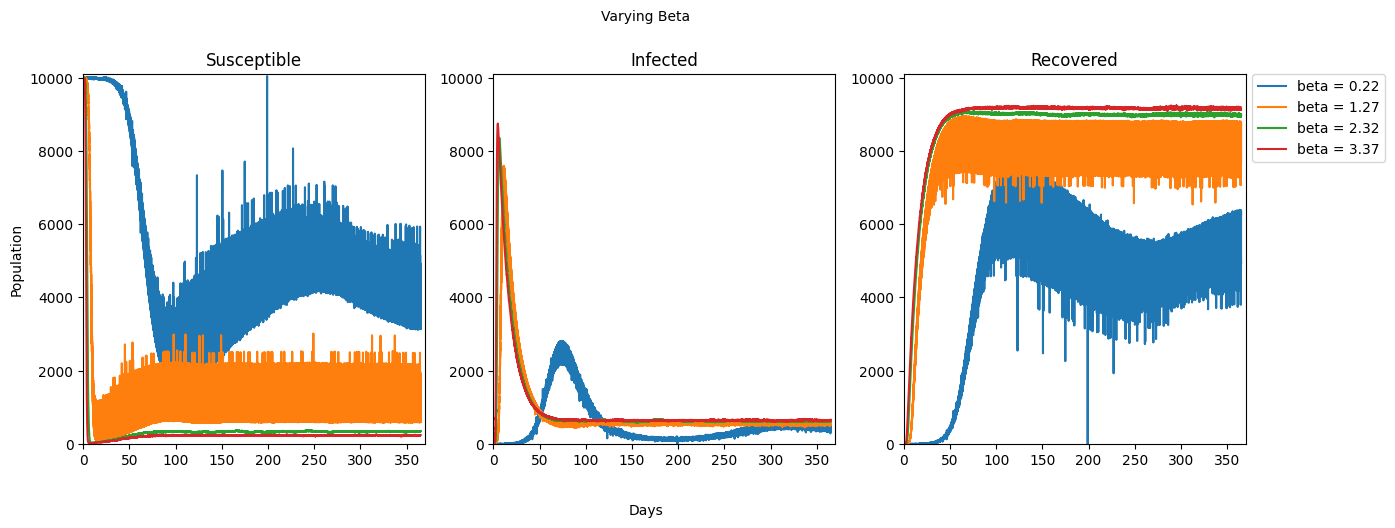

In [12]:
#Reading in the beta data (lol it rhymes hee hee. I'm a bit delirious right now). 

def sortHelper(x):
    try:
        return float(x)
    except: 
        return 100000
dfs = [beta_df, gamma_df, mu_df, N_df, gamma_N_df]

for df in dfs:
    df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1, inplace=True) 

sorted_columns = sorted(beta_df.columns, key=sortHelper)

beta_df = beta_df.reindex(columns=sorted_columns)

grouped = beta_df.groupby(["group"])
grouped_beta = beta_df.groupby(["group", "beta"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in beta_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data


for paramVal in beta_df["beta"].unique()[1::5]:
    axs[0].plot(numbers, grouped_beta.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_beta.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_beta.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"beta = {paramVal:.{2}f}")
    cov = np.cov(grouped_beta.loc[("S", paramVal)][:-6].dropna(), grouped_beta.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_beta.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_beta.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_beta.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Beta", ha='center', va='center', rotation='horizontal')
legend_labels = [f"beta = {paramVal:.{2}f}" for paramVal in beta_df["beta"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


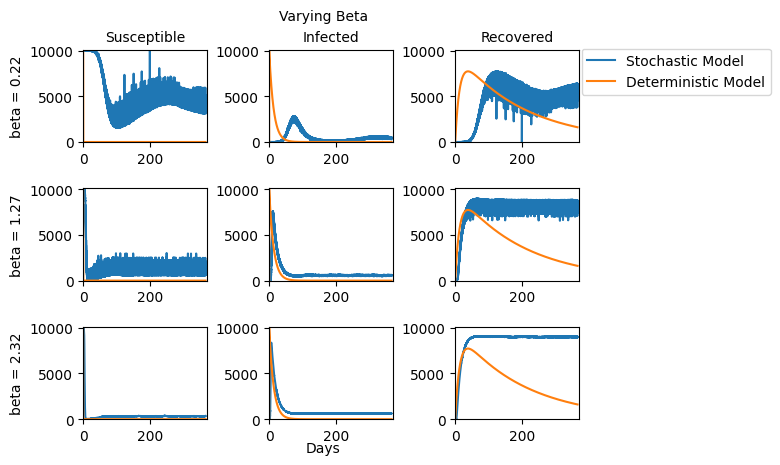

In [21]:
#Setting the figure
fig, axs = plt.subplots(3, 3)

# Plotting the data
t1 = np.linspace(0, 365, len(numbers))

for i in range(3): 
    paramVals = beta_df["beta"].unique()[1::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (paramVals[i], beta_df["gamma"][0], beta_df["mu"][0]))
    axs[i,0].plot(numbers, grouped_beta.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_beta.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_beta.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"beta = {round(paramVals[i], 2)}")
    
    
axs[0,0].set_title("Susceptible", fontsize = 10)
axs[0,1].set_title("Infected", fontsize = 10)
axs[0,2].set_title("Recovered", fontsize = 10)


fig.text(0.5, 0.05, "Days", ha='center', va='center')
fig.text(0.5, 0.95, "Varying Beta", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 4.01), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


gamma = 0.22
Covariance between S and I = -35396.72955239162

Variance for S = 748107.9335788947
Variance for I = 19772.217871259578
Variance for R = 691527.3923112763

gamma = 0.14
Covariance between S and I = -110615.7982919235

Variance for S = 1808768.777221275
Variance for I = 147259.15577635003
Variance for R = 1756228.3332891809

gamma = 0.29
Covariance between S and I = -15771.541749126556

Variance for S = 506887.1635694167
Variance for I = 5273.948517134851
Variance for R = 474101.2710355077
gamma = 0.42
Covariance between S and I = -0.12241481192293355

Variance for S = 505.0947846553558
Variance for I = 0.005381580038494857
Variance for R = 0.2208187946621726


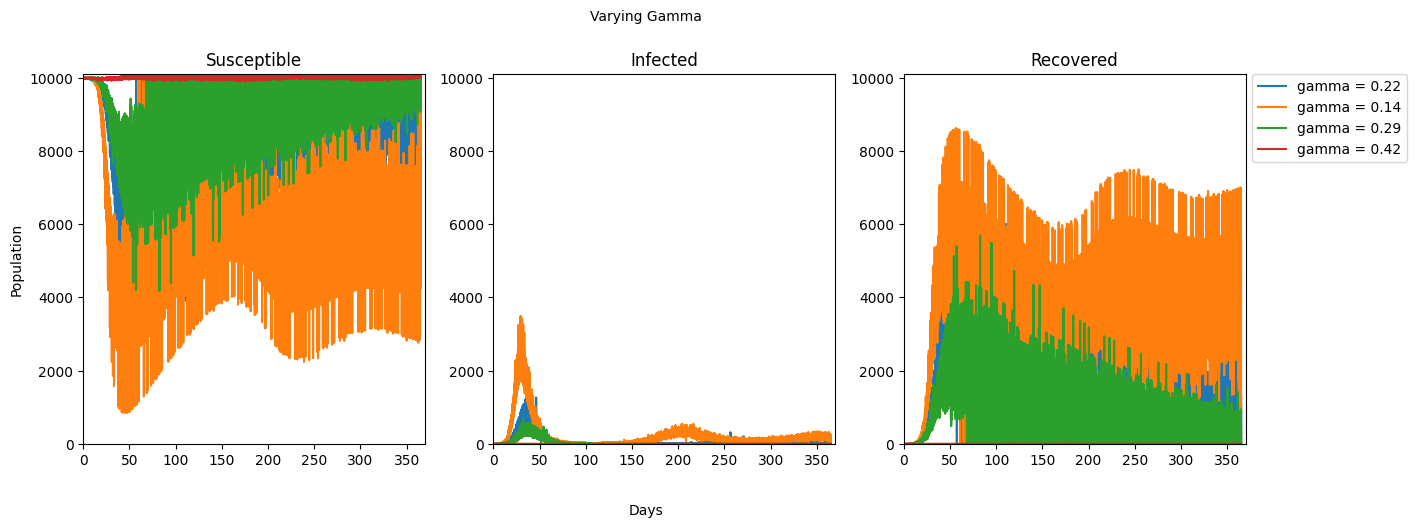

In [22]:
#Reading in the gamma data (lol it rhymes hee hee. I'm a bit delirious right now). ### You and me both buddy

grouped = gamma_df.groupby(["group"])
grouped_gamma = gamma_df.groupby(["group", "gamma"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in gamma_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data

for paramVal in gamma_df["gamma"].unique()[1::5]:
    axs[0].plot(numbers, grouped_gamma.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_gamma.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_gamma.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"gamma = {paramVal:.{2}f}")
    cov = np.cov(grouped_gamma.loc[("S", paramVal)][:-6].dropna(), grouped_gamma.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_gamma.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_gamma.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_gamma.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Gamma", ha='center', va='center', rotation='horizontal')
legend_labels = [f"gamma = {paramVal:.{2}f}" for paramVal in gamma_df["gamma"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


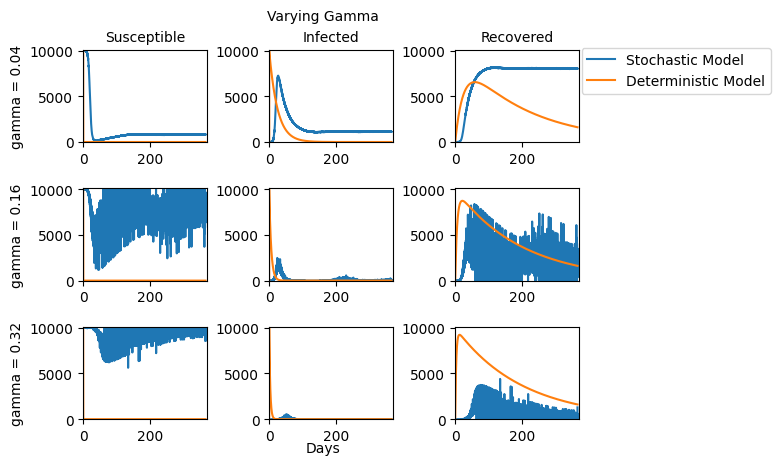

In [23]:
#Setting the figure
fig, axs = plt.subplots(3, 3)
# fig.set_figwidth(8)
# fig.set_figheight(8)
# Plotting the data

t1 = np.linspace(0, 365, len(numbers))


for i in range(3): 
    paramVals = gamma_df["gamma"].unique()[2::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (gamma_df["beta"][0], paramVals[i], gamma_df["mu"][0]))
    axs[i,0].plot(numbers, grouped_gamma.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_gamma.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_gamma.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"gamma = {round(paramVals[i], 2)}")

axs[0,0].set_title("Susceptible", fontsize = 10)
axs[0,1].set_title("Infected", fontsize = 10)
axs[0,2].set_title("Recovered", fontsize = 10)


fig.text(0.5, 0.05, "Days", ha='center', va='center')
fig.text(0.5, 0.95, "Varying Gamma", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 4.02), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


mu = 0.02
Covariance between S and I = -444072.0135004547

Variance for S = 2047138.142519091
Variance for I = 324274.7228861258
Variance for R = 1475193.5723492906

mu = 0.07
Covariance between S and I = -623933.7494230488

Variance for S = 1329278.0570609288
Variance for I = 324541.8537938637
Variance for R = 399028.5122747744


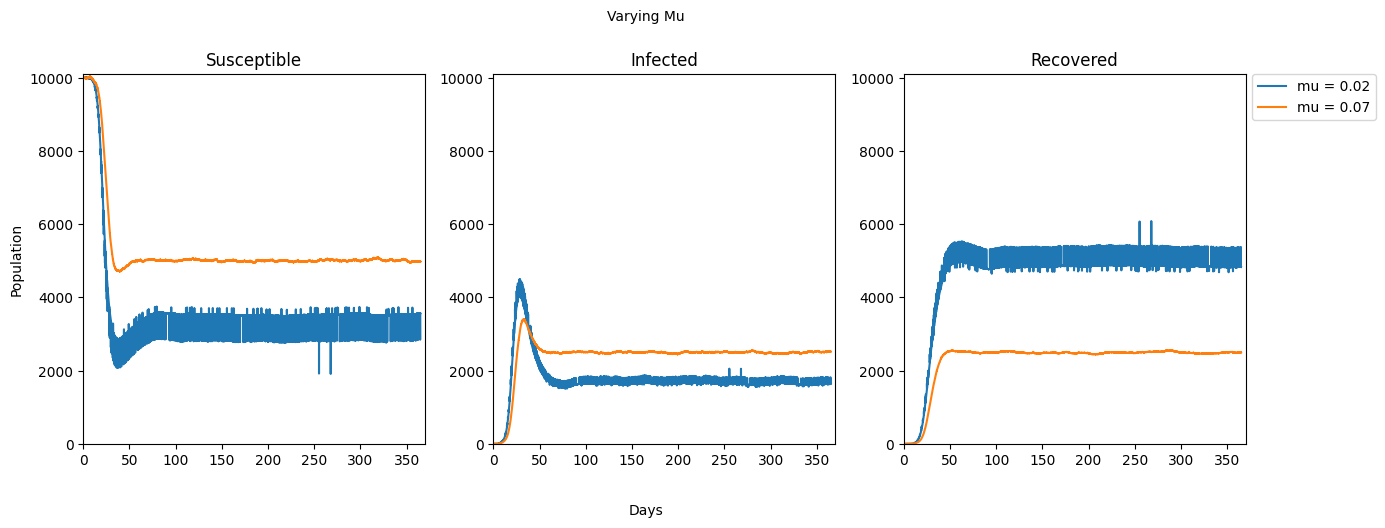

In [24]:
#Reading in the Mu data (lol it rhymes hee hee. I'm a bit delirious right now). 

grouped = mu_df.groupby(["group"])
grouped_mu = mu_df.groupby(["group", "mu"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in mu_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(15)

# Plotting the data

for paramVal in mu_df["mu"].unique()[1::5]:
    axs[0].plot(numbers, grouped_mu.loc[("S", paramVal)][:-6])
    axs[0].set_title("Susceptible")
    axs[0].set_ylabel("Population")
    axs[1].plot(numbers, grouped_mu.loc[("I", paramVal)][:-6])
    axs[1].set_title("Infected")
    axs[2].plot(numbers, grouped_mu.loc[("R", paramVal)][:-6])
    axs[2].set_title("Recovered")
    print(f"mu = {paramVal:.{2}f}")
    cov = np.cov(grouped_mu.loc[("S", paramVal)][:-6].dropna(), grouped_mu.loc[("I", paramVal)][:-6].dropna())
    print(f"Covariance between S and I = {cov[0,1]}")
    print()
    
    var_s = np.var(grouped_mu.loc[("S", paramVal)][:-6].dropna())
    var_i = np.var(grouped_mu.loc[("I", paramVal)][:-6].dropna())
    var_r = np.var(grouped_mu.loc[("R", paramVal)][:-6].dropna())
    print(f"Variance for S = {var_s}")
    print(f"Variance for I = {var_i}")
    print(f"Variance for R = {var_r}")
    print()


fig.text(0.5, -0.03, "Days", ha='center', va='center')
fig.text(0.5, 1.0, "Varying Mu", ha='center', va='center', rotation='horizontal')
legend_labels = [f"mu = {paramVal:.{2}f}" for paramVal in mu_df["mu"].unique()[1::5]]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.show()


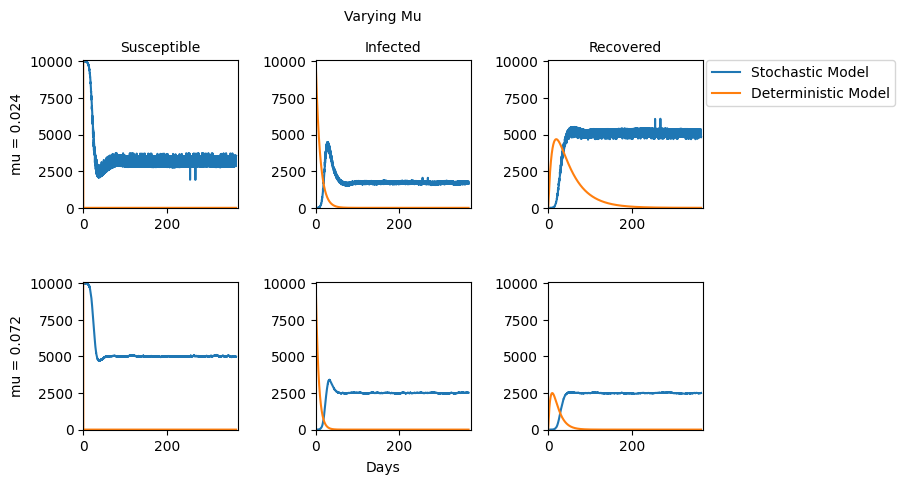

In [25]:
#Setting the figure
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(8)

# Plotting the data

t1 = np.linspace(0, 365, len(numbers))


for i in range(2): 
    paramVals = mu_df["mu"].unique()[1::5]
    solved = odeint(determinsteSIR, [10000, 1, 0], t1, (mu_df["beta"][0], mu_df["gamma"][0], paramVals[i]))
    axs[i,0].plot(numbers, grouped_mu.loc[("S", paramVals[i])][:-6], numbers, solved[:,0])
    axs[i,1].plot(numbers, grouped_mu.loc[("I", paramVals[i])][:-6], numbers, solved[:,1])
    axs[i,2].plot(numbers, grouped_mu.loc[("R", paramVals[i])][:-6], numbers, solved[:,2])
    axs[i,0].set_ylabel(f"mu = {round(paramVals[i], 3)}")


axs[0,0].set_title("Susceptible", fontsize = 10)
axs[0,1].set_title("Infected", fontsize = 10)
axs[0,2].set_title("Recovered", fontsize = 10)


fig.text(0.5, 0.03, "Days", ha='center', va='center')
fig.text(0.5, 0.97, "Varying Mu", ha='center', va='center', rotation='horizontal')
legend_labels = ["Stochastic Model", "Deterministic Model"]
plt.legend(legend_labels, bbox_to_anchor=(1.02, 2.5), loc='upper left', borderaxespad=0)
plt.setp(axs, xlim=(0,370), ylim=(0,10100))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

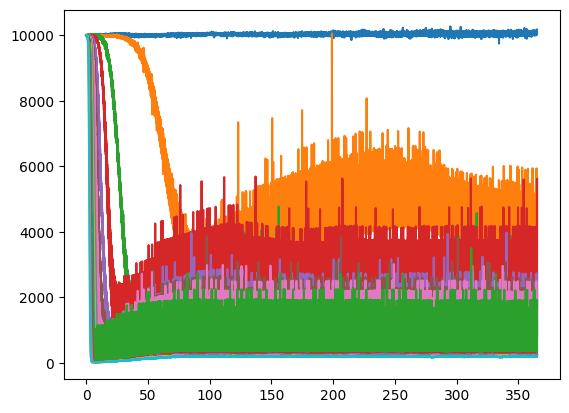

In [26]:
grouped = beta_df.groupby(["group"])
grouped_beta = beta_df.groupby(["group", "beta"]).mean(numeric_only=True)
mean_stoch = grouped.mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in beta_df.columns[1:-6]]

# Plotting the data
#plt.plot(numbers, mean_stoch.loc["S"][:-7])
for i in beta_df["beta"].unique():
    plt.plot(numbers, grouped_beta.loc[("S", i)][:-5])

plt.show()


## Stochastic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance around the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

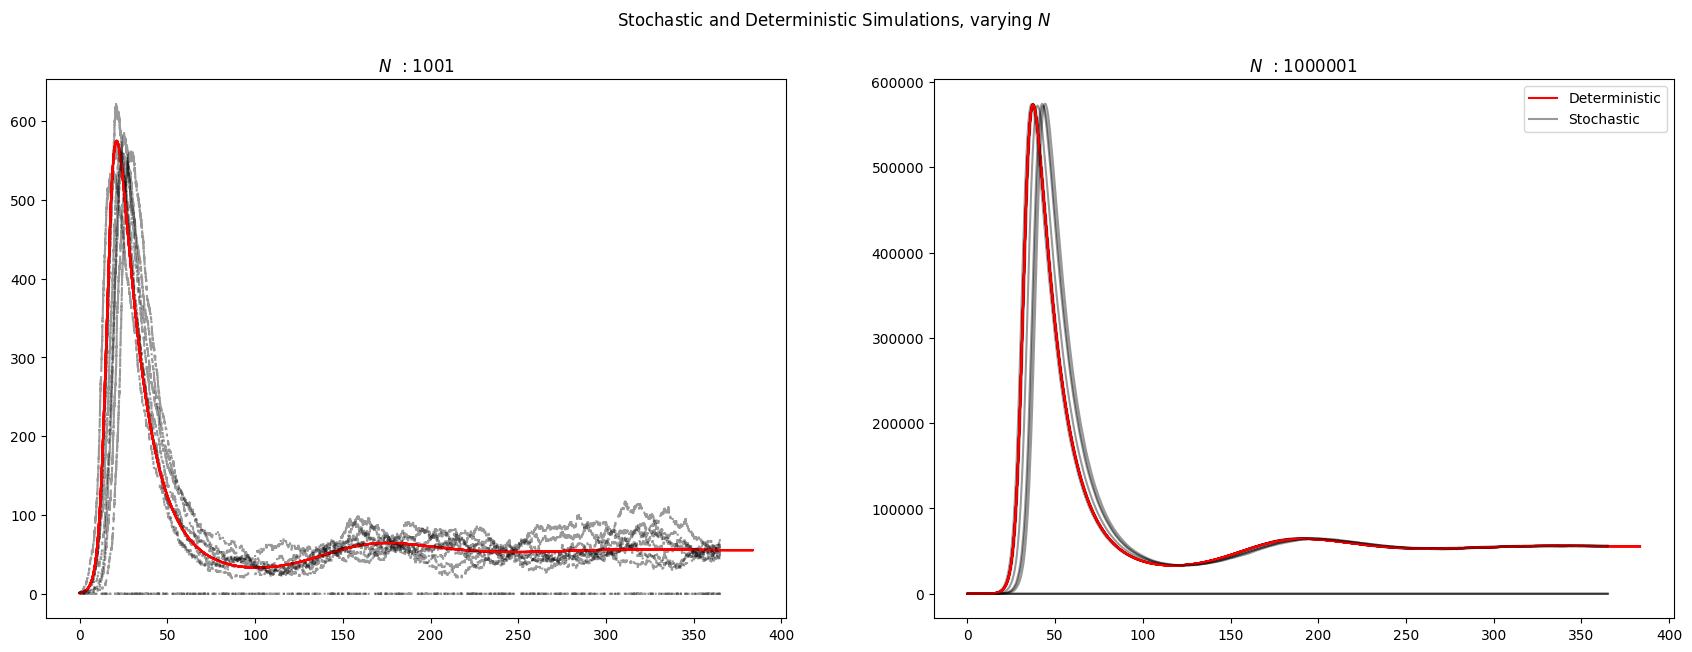

In [45]:
def plt_row(df, param):
    values = df[param].unique()
    values.sort()
    idx = np.linspace(0, len(values)-1, 2).astype(int)
    
    for plot, current_param in enumerate(values[idx]):
        intervals = [float(x) for x in df.columns[1:-6]]
        filtered_df = df.loc[(df[param] == current_param) & (df["group"] == "I")]
        
        for i in range(10):
            kwargs = {}
            parameters = ["beta","gamma","mu","N"]
            parameters.remove(param)
            
            for x in parameters:
                kwargs[x] = df[x].unique()[0]
            kwargs[param] = current_param
            
            determinist_data = return_Solved(**kwargs, steps = len(intervals))[:, 1] * kwargs["N"]
            mult = current_param ** (param == "N") #If we are currently plotting for change in N, we need to multiply by N because the data was normalized to 1
            if i == 0:
                axs[plot].plot(intervals, determinist_data, color="r",label = "Deterministic")
                axs[plot].plot(intervals, filtered_df.iloc[i, 1:-6] * mult, color ="black", alpha= 0.4, label = "Stochastic")
            else:
                axs[plot].plot(intervals, determinist_data, color="r")
                axs[plot].plot(intervals, filtered_df.iloc[i, 1:-6] * mult, color ="black", alpha= 0.4)
            if param == "N":
                axs[plot].set_title(f"${param}$  : {int(current_param)}")
            else:
                axs[plot].set_title(f"$\{param}$  : {current_param:.2f}")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plt_row(beta_df.loc[(0.1 < beta_df["beta"]) & (beta_df["beta"] < 0.85)], "beta")
fig.suptitle("Stochastic and Deterministic Simulations, varying $\\beta$")
axs[1].legend(loc="best")
fig.savefig("beta_transient")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plt_row(gamma_df.loc[(0.05 < gamma_df["gamma"]) & (gamma_df["gamma"] < 0.3 )], "gamma")
fig.suptitle("Stochastic and Deterministic Simulations, varying $\gamma$")
axs[1].legend(loc="best")
fig.savefig("gamma_transient")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plt_row(mu_df, "mu")
fig.suptitle("Stochastic and Deterministic Simulations, varying $\mu$")
axs[1].legend(loc="best")
fig.savefig("mu_transient")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plt_row(N_df.loc[N_df["N"] > 999], "N")
fig.suptitle("Stochastic and Deterministic Simulations, varying $N$")
axs[1].legend(loc="best")
fig.savefig("N_transient")

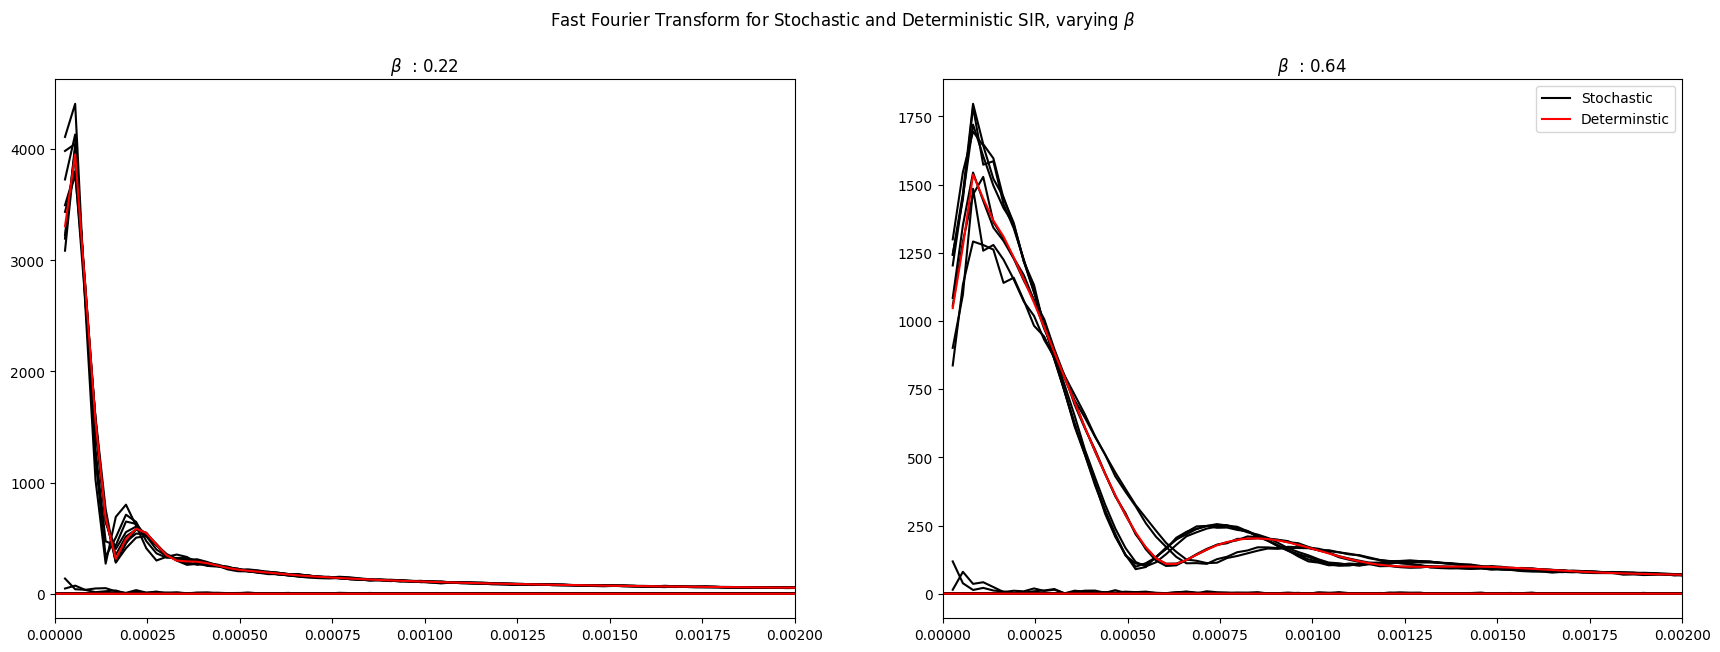

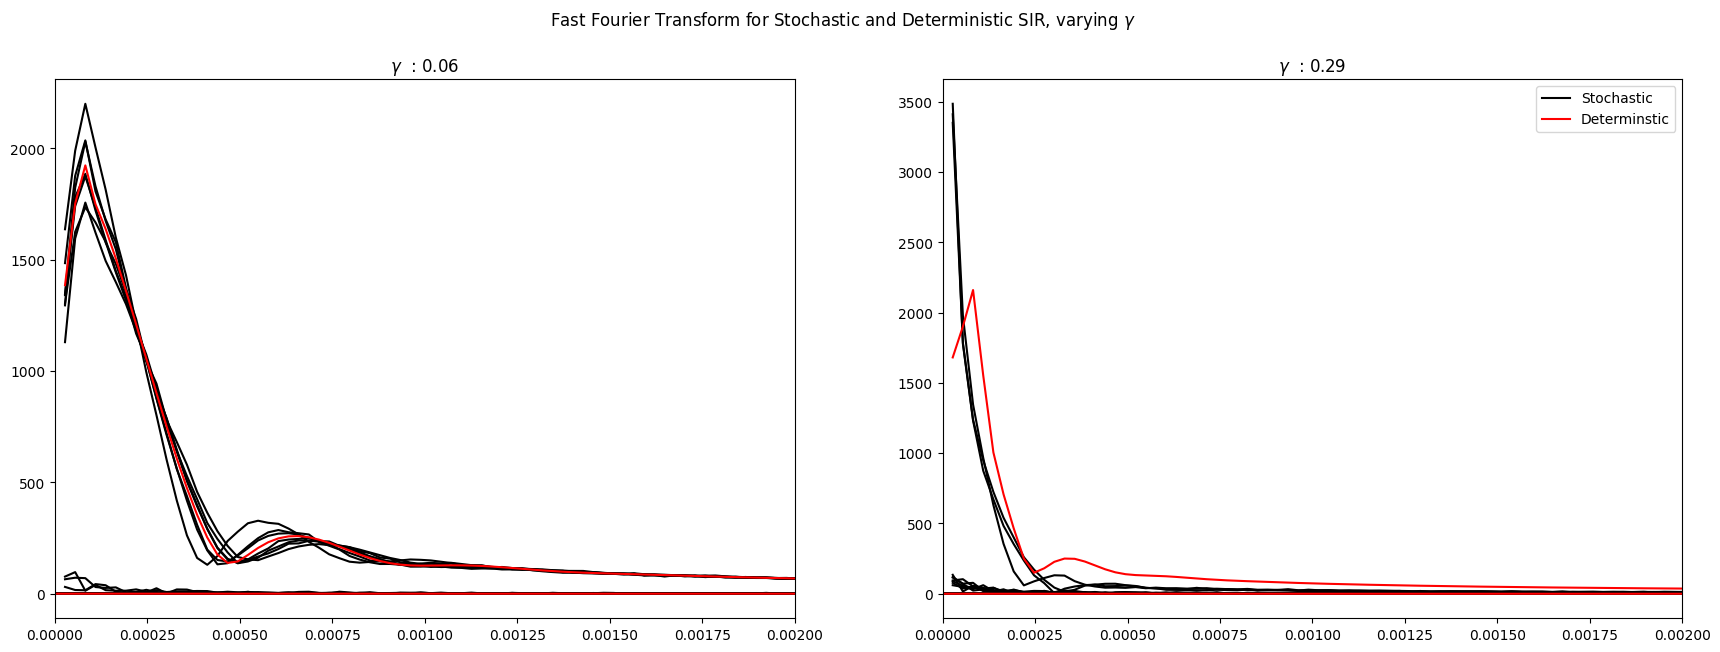

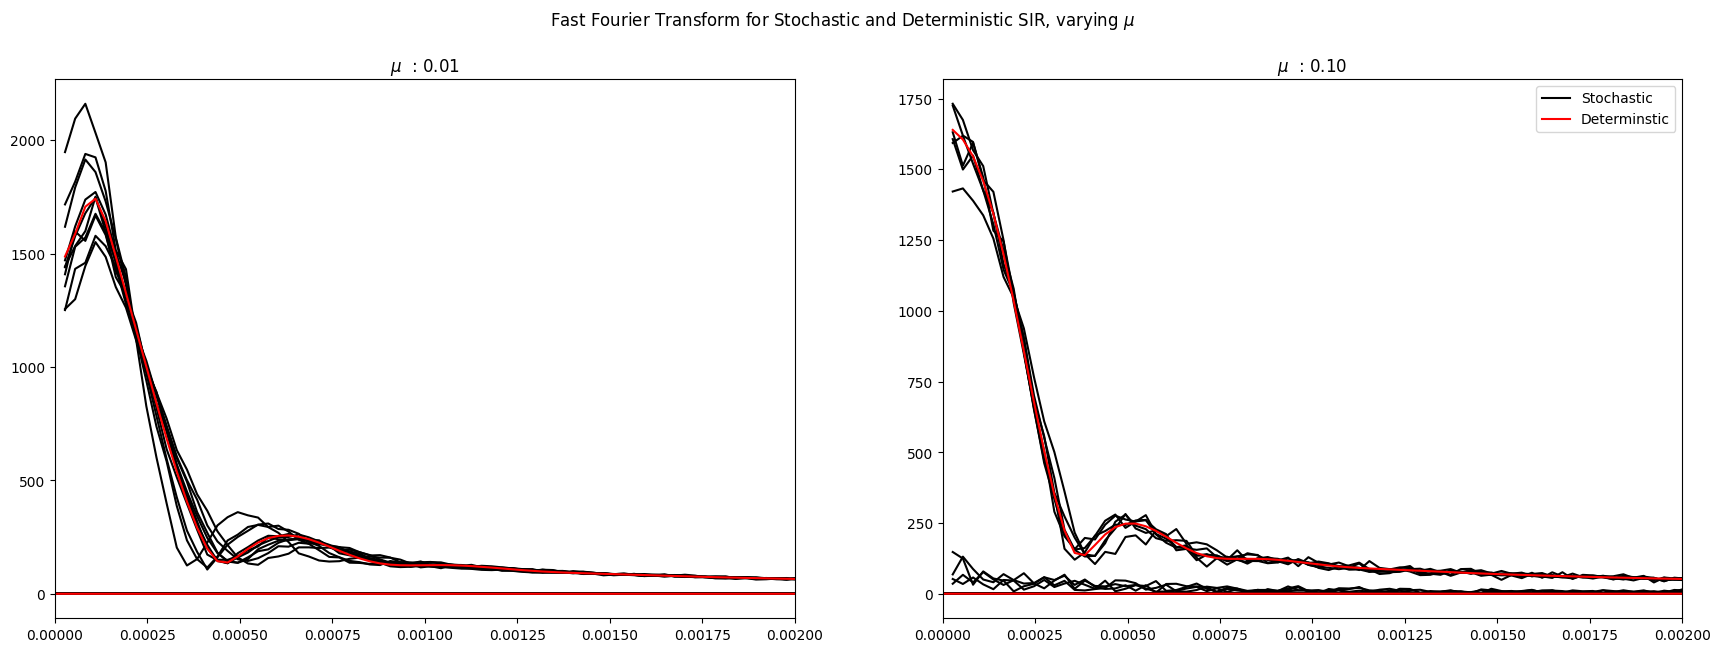

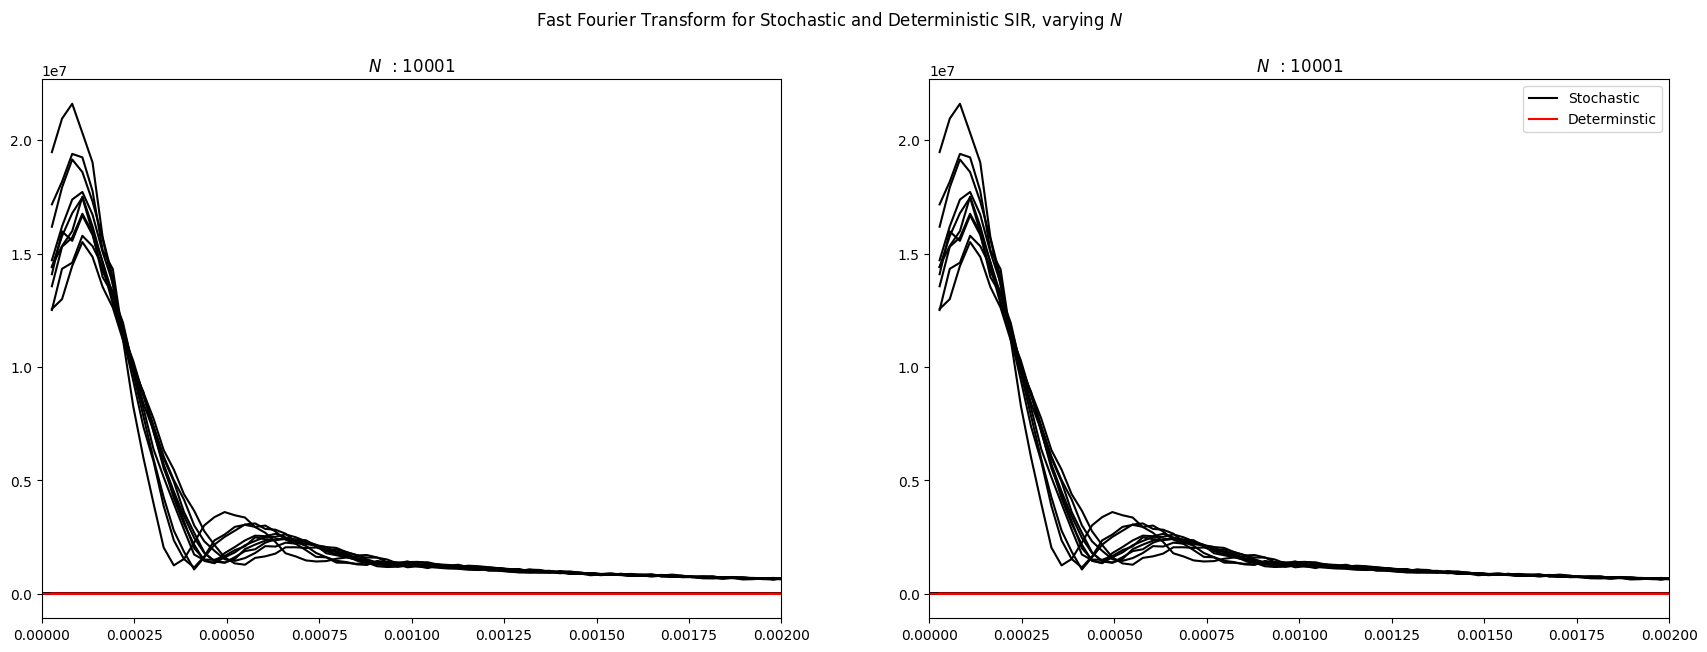

In [34]:
## When you really think about it, has FFT every made anyone happy? I this a method we really need to be condoning in research?? I think not, let's stop the FFT tyranny and accept that our eyes can just see the waves
def get_fft(data):
    data -= np.mean(data)
    fft_result = fft(data)
    frequencies = fftfreq(len(data))
    
    non_zero = np.where(frequencies != 0.0)
    frequencies = frequencies[non_zero]
    fft_result = fft_result[non_zero]
    magnitudes = np.abs(fft_result)
    return frequencies, magnitudes
    
def plotFFT(df, param):
    values = df[param].unique()
    values.sort()
    idx = np.linspace(0, len(values)-1, 2).astype(int)

    kwargs = {}
    parameters = ["beta","gamma","mu","N"]
    parameters.remove(param)
    for x in parameters:
        kwargs[x] = df[x].unique()[0]
    
    intervals = [float(x) for x in df.columns[1:-6]]
    for plot,i in enumerate(values[idx], start = 0):
        mult = i ** (param == "N") #If we are currently plotting for change in N, we need to multiply by N because the data was normalized to 1
        kwargs[param] = i 
        for x in range(10):
            stochastic_data = df.loc[(df[param] == i) & (df["group"] == "S")].iloc[x][:36400]
            stochastic_data.ffill(inplace=True)
            stochastic_data.bfill(inplace=True) #For some reason first data point sometimes is a NaN
            stochastic_data = stochastic_data.to_numpy() 
            stochastic_data *= mult 
            stochastic_freqs, stochastic_mags = get_fft(stochastic_data)
            stochastic_mags /= kwargs["N"]
            
            if x == 0: 
                axs[plot].plot(stochastic_freqs, stochastic_mags, color = "black", label = "Stochastic")
            else:
                axs[plot].plot(stochastic_freqs, stochastic_mags, color = "black")
                
        determinist_data = return_Solved(**kwargs, steps = len(intervals))[:36400, 0] * kwargs["N"]
        determinist_freqs, determinist_mags = get_fft(determinist_data)
        determinist_mags /= kwargs["N"]
        axs[plot].plot(determinist_freqs, determinist_mags, color = "r", label = "Determinstic")
        if param == "N":
            axs[plot].set_title(f"${param}$  : {int(i)}")
        else:
            axs[plot].set_title(f"$\{param}$  : {i:.2f}")
        axs[plot].set_xlim((0,.002))

# plotFFT(beta_df.loc[(0.1 < beta_df["beta"]) & (beta_df["beta"] < 0.85)], "beta", 0)
# plotFFT(gamma_df.loc[(0.05 < gamma_df["gamma"]) & (gamma_df["gamma"] < 0.3)], "gamma",3)
# plotFFT(mu_df, "mu",6)
# plotFFT(N_df.loc[N_df["N"] > 999], "N",9)
# axs[2].legend(bbox_to_anchor=(1.02, 1.5), loc='upper left', borderaxespad=0)
# # plt.tight_layout()
# plt.savefig("resonance", dpi=500)
fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plotFFT(beta_df.loc[(0.1 < beta_df["beta"]) & (beta_df["beta"] < 0.85)], "beta")
fig.suptitle("Fast Fourier Transform for Stochastic and Deterministic SIR, varying $\\beta$")
axs[1].legend(loc="best")
fig.savefig("beta_FFT")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plotFFT(gamma_df.loc[(0.05 < gamma_df["gamma"]) & (gamma_df["gamma"] < 0.3 )], "gamma")
fig.suptitle("Fast Fourier Transform for Stochastic and Deterministic SIR, varying $\gamma$")
axs[1].legend(loc="best")
fig.savefig("gamma_FFT")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plotFFT(mu_df, "mu")
fig.suptitle("Fast Fourier Transform for Stochastic and Deterministic SIR, varying $\mu$")
axs[1].legend(loc="best")
fig.savefig("mu_FFT")

fig, axs = plt.subplots(1, 2, figsize=(21, 7))
axs = axs.ravel()
plotFFT(N_df.loc[N_df["N"] > 999], "N")
fig.suptitle("Fast Fourier Transform for Stochastic and Deterministic SIR, varying $N$")
axs[1].legend(loc="best")
fig.savefig("N_FFT")


## Stochastic Resonance and Increase Transients
> Show how the stochatic models can induce stochatic resonance around the equilibiruim and how that resonance relates to the paramters.

> Show some example of increased transients away from the deterministic equilibiruim. Which parameters lead to the largest transient?

## Extinction events and Critical Community Size
> Design an experiment that shows the effect of varying $R_0$ on the extinction process. *Keep in mind that in the closed system randomness will always eventually lead to extinction*. 

> Look at how the extinction events are impacted by the population size. Find a way to show how the two parameter $R_0$ and $N$ ineract to impact the extinction process.

IndexError: index 0 is out of bounds for axis 0 with size 0

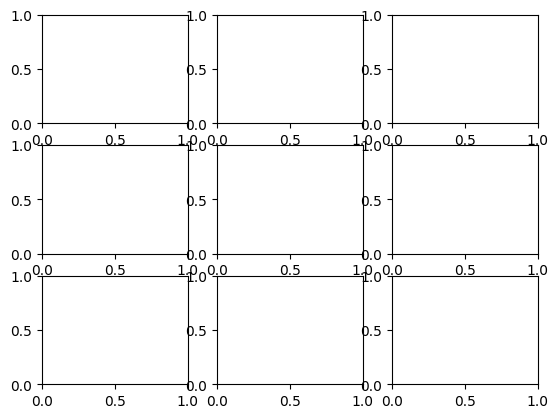

In [35]:
grouped = gamma_N_df.groupby(["group"])
grouped_R = gamma_N_df.groupby(["group", "N", "gamma"]).mean(numeric_only=True)

# Extract column numbers for plotting
numbers = [float(x) for x in gamma_N_df.columns[1:-7]]

#Setting the figure
fig, axs = plt.subplots(3, 3)

# Plotting the data
paramVals_N = gamma_N_df["N"].unique()[:-1]
paramVals_gamma = gamma_N_df["gamma"].unique()[1::3]
paramVals_gamma = paramVals_gamma[::-1]

for i in range(3): 
    for j in range(3):
        axs[i,j].plot(numbers, grouped_R.loc[("S", paramVals_N[i], paramVals_gamma[j])][:-5], label='Susceptible')
        axs[i,j].plot(numbers, grouped_R.loc[("I", paramVals_N[i], paramVals_gamma[j])][:-5], label='Infected')
        axs[i,j].plot(numbers, grouped_R.loc[("R", paramVals_N[i], paramVals_gamma[j])][:-5], label='Recovered')
    axs[i,0].set_ylabel(f"N = {round(paramVals_N[i], 2)}")
    axs[0,i].set_title(f"R_0 = {round(0.5/(paramVals_gamma[i] + 0.005), 2)}", fontsize = 10)

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 4.09))
fig.text(0.5, 0.03, "Days", ha='center', va='center')
fig.text(0.5, 0.97, "Varying R_0 and N", ha='center', va='center', rotation='horizontal')
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()


## SIR Model on Networks

In [53]:
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cpm

class Simulation():
    def __init__(self, graph, iterations, tests, testIter, accuracy, vaccines, infected, beta, gamma, vaccination_strat, testing_strat):
        """Init the simulation with a graph, the total number of available tests, the number of vaccines for each iteration, the number of infected individuals at the start and the vaccination strategy"""
        self.graph = graph
        self.iterations = iterations
        self.tests = tests
        self.testIter = testIter
        self.accuracy = accuracy
        self.vaccines = vaccines
        self.infected = infected
        self.beta = beta
        self.gamma = gamma
        self.Nnodes= len(self.graph.nodes())
        self.testing = testing_strat
        self.prep_vaccine = vaccination_strat



        self.id= {n: {"id": id} for id,n in enumerate(self.graph.nodes())}
        self.checked = {n: {"check": "Susceptible"} for i,n in enumerate(self.graph.nodes())}
        nx.set_node_attributes(self.graph, self.id)
        nx.set_node_attributes(self.graph, self.checked)

        self.current_iteration = 0
        self.vaccine_targets = []
        self.history= []
        self.iterationBunch = []
        self.model = None
        self.trends = None
        self.testing_target = None
        self.vaccine_target= None

    def setup_model(self):
        self.trends =  None
        self.model = gc.CompositeModel(self.graph)

        self.model.add_status("Susceptible")
        self.model.add_status("Infected")
        self.model.add_status("Recovered")
        config = mc.Configuration()
        infections = np.random.randint(self.Nnodes, size=self.infected)
        config.add_model_initial_configuration("Infected", infections)


        # c1 and c2 are the rules for spread and recovered, the trigger status means that it is based on the number of neighbors
        c1 = cpm.NodeStochastic(self.beta, triggering_status="Infected")
        c2 = cpm.NodeStochastic(self.gamma)
        self.model.add_rule("Susceptible", "Infected", c1)
        self.model.add_rule("Infected", "Recovered", c2)

        self.model.set_initial_status(config)


    def vaccination(self):
        for node in self.graph.nodes():
            if node in self.vaccine_targets and self.model.status[node] == 0:
                self.model.status[node] = 2
        [self.history.append(x) for x in self.vaccine_targets]
        self.vaccine_targets = []

    def run(self, N):
        S = np.ndarray((N,self.iterations))
        I = np.ndarray((N,self.iterations))
        R = np.ndarray((N,self.iterations))
        for _ in range(N):
            for i in range(self.iterations):
                if self.tests:
                    self.testing(self, self.accuracy)
                self.prep_vaccine(self)
                self.vaccination()
                self.iterationBunch.append(self.model.iteration())
            data = self.model.build_trends(self.iterationBunch)[0]['trends']['node_count']
            self.history = []
            S[_,:] =  data[0][-self.iterations:]
            I[_,:] =  data[1][-self.iterations:]
            R[_,:] =  data[2][-self.iterations:]
            self.setup_model()
            self.model.reset()
        return [S,I,R]

def baseline(args, test=False):
    pass

def plot_data(data, ax, percentile=90, title=False, individual=True):
    S,I,R = data[0],data[1],data[2]
    meanS = np.mean(S,axis=0)
    meanI = np.mean(I,axis=0)
    meanR = np.mean(R,axis=0)

    varS = np.std(S,axis=0)
    varI = np.std(I,axis=0)
    varR = np.std(R,axis=0)

    x_axis = range(len(meanS))
    if title:
        ax.set_title(title)
    for mean,var in [(meanS,varS),(meanI,varI),(meanR,varR)]:
        ax.plot(x_axis, mean)
        ax.fill_between(x_axis, mean + 0.45*var, mean- 0.45*var, alpha= 0.5)
    if individual:
        for i in range(S.shape[0]):
            ax.plot(x_axis, S[i], color = "b")
            ax.plot(x_axis, I[i], color = "orange")
            ax.plot(x_axis, R[i], color = "g")
    print(max(meanI))
    ax.axhline(max(meanI), color="gray", alpha=.3)
    return ax

def stackedplot_data(data, ax, percentile=90, label=None, individual=True, color=0):
    colors = ["#93B7BE", "#E0CA3C", "#A799B7","#048A81"]
    I = data[1]
    mean = np.mean(I,axis=0)

    var = np.std(I,axis=0)

    x_axis = range(len(mean))
    ax.plot(x_axis, mean,color=colors[color], label = label)
    ax.fill_between(x_axis, mean + 0.45*var, mean- 0.45*var, alpha= 0.5, color=colors[color])
    # for i in range(0,I.shape[0],5):
    #     ax.plot(x_axis, I[i], alpha=.3,color=colors[color])
    print(max(mean))
    ax.axhline(max(mean), color="gray", alpha=.3)
    return ax


In [37]:

# 
# 
# # nx.draw_networkx_edges(graph,pos=nx.spring_layout(graph))
# def give_plot(graph, rule=None):
#     model = ep.SIRModel(graph)
# 
#     ## configuring model
# 
#     config = mc.Configuration()
#     config.add_model_parameter("beta", 1 / 20)
#     config.add_model_parameter("gamma", 1/40)
#     config.add_model_parameter("fraction_infected", 50/len(graph.nodes))
#     model.set_initial_status(config)
# 
#     ## Excuting the simulation
# 
#     trends = multi_runs(model, execution_number=4, iteration_number = 200, nprocesses=4) 
# 
#     ## Visualizing
#     visual = DiffusionTrend(model, trends)
#     return visual.plot(percentile=95)



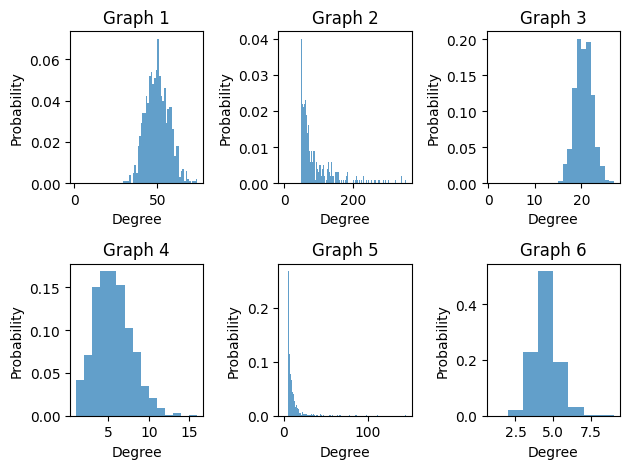

In [60]:
for i, graph in enumerate(graphs):
    plt.subplot(2, 3, i + 1)
    degrees = [degree for node, degree in graph.degree()]
    plt.hist(degrees, bins=range(1, max(degrees) + 2), density=True, alpha=0.7)
    plt.title(f'Graph {i + 1}')
    plt.xlabel('Degree')
    plt.ylabel('Probability')

plt.tight_layout()
plt.show()

446.1
451.9
442.6666666666667
350.46666666666664
431.76666666666665
221.13333333333333


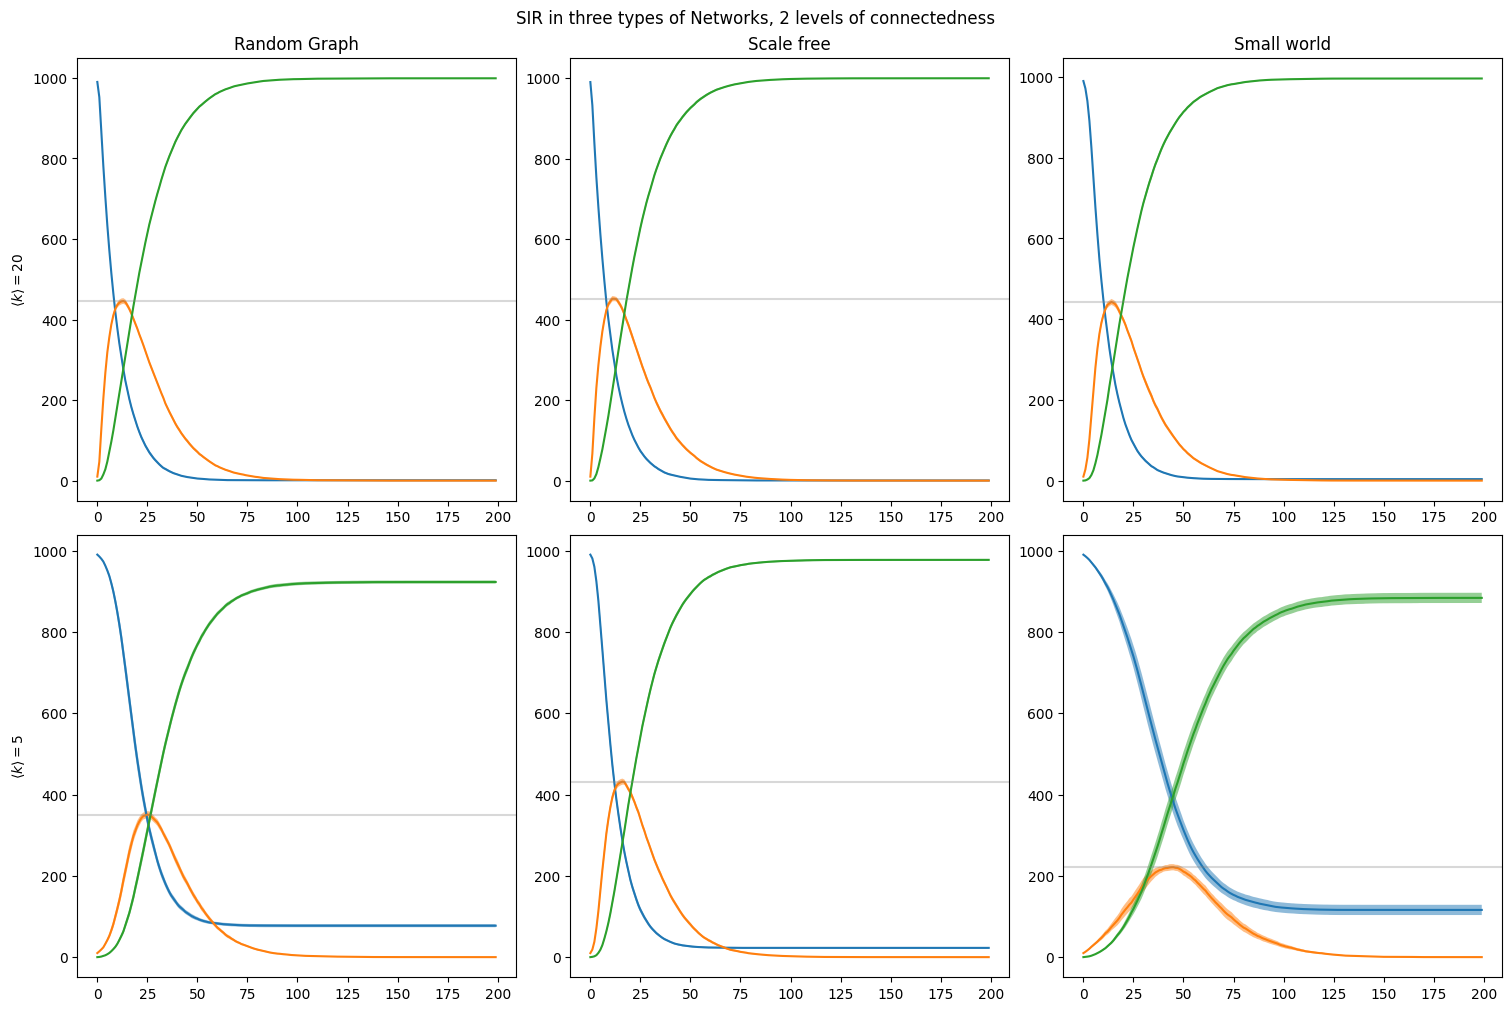

In [58]:

graphER = nx.erdos_renyi_graph(1000, 0.05)
graphER2 = nx.erdos_renyi_graph(1000, 0.005)
graphBA = nx.barabasi_albert_graph(1000, 50)
graphBA2 = nx.barabasi_albert_graph(1000, 5)
graphWS = nx.watts_strogatz_graph(1000,20,0.2)
graphWS2 = nx.watts_strogatz_graph(1000,5,0.2)

graphs = [graphER,  graphBA,  graphWS,graphER2, graphBA2,graphWS2]

plotnames = [  "Random Graph",
               "Scale free",
               "Small world",
]
kwargs = {
    "graph": None,
    "iterations": 200,
    "tests": 200,
    "testIter":10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 10,
    "beta": 1/10 ,
    "gamma": 1/14,
    "vaccination_strat": baseline,
    "testing_strat": baseline,
}
runs = 30
fig,ax = plt.subplots(2,3, figsize=(15,10), layout="constrained")


for plot,graph in enumerate(graphs):
    kwargs["graph"] = graph
    sim = Simulation(**kwargs)
    sim.setup_model()
    base_data = sim.run(runs)
    if plot < 3:
        title = plotnames[plot]
    else:
        title = False
    plot_data(base_data, ax.flat[plot], 90, title, individual=False)
fig.suptitle("SIR in three types of Networks, 2 levels of connectedness")
plt.setp(ax[0,0], ylabel='$\langle k \\rangle = 20$')
plt.setp(ax[1,0], ylabel='$\langle k \\rangle = 5$')
fig.savefig("networks")


## SIR NETWORKS
In SIR networks, beta should(?) be smaller than gamma in order to get similar behavior to a regular SIR. Not true?

ER: Homogenous mixing, and we expect all nodes to have the "average" number of edges, which leads to little to no pockets for the infection to get stuck in. Changing beta 
 - For low value of P, the disease does not infect all susceptibles, it most likely gets stuck source:Amir

BA: Any node is most likely connected to a hub, therefore it is very unlikely to get "stuck" somewhere where the disease has no susceptibles to spread to. 

WS: When taking k to be the mean degree of an ER model and setting P to 1, we expect WS and ER to behave very similarly. considering the graph is now fully randomly initialize.


157.4
131.33333333333334
77.06666666666666
124.9


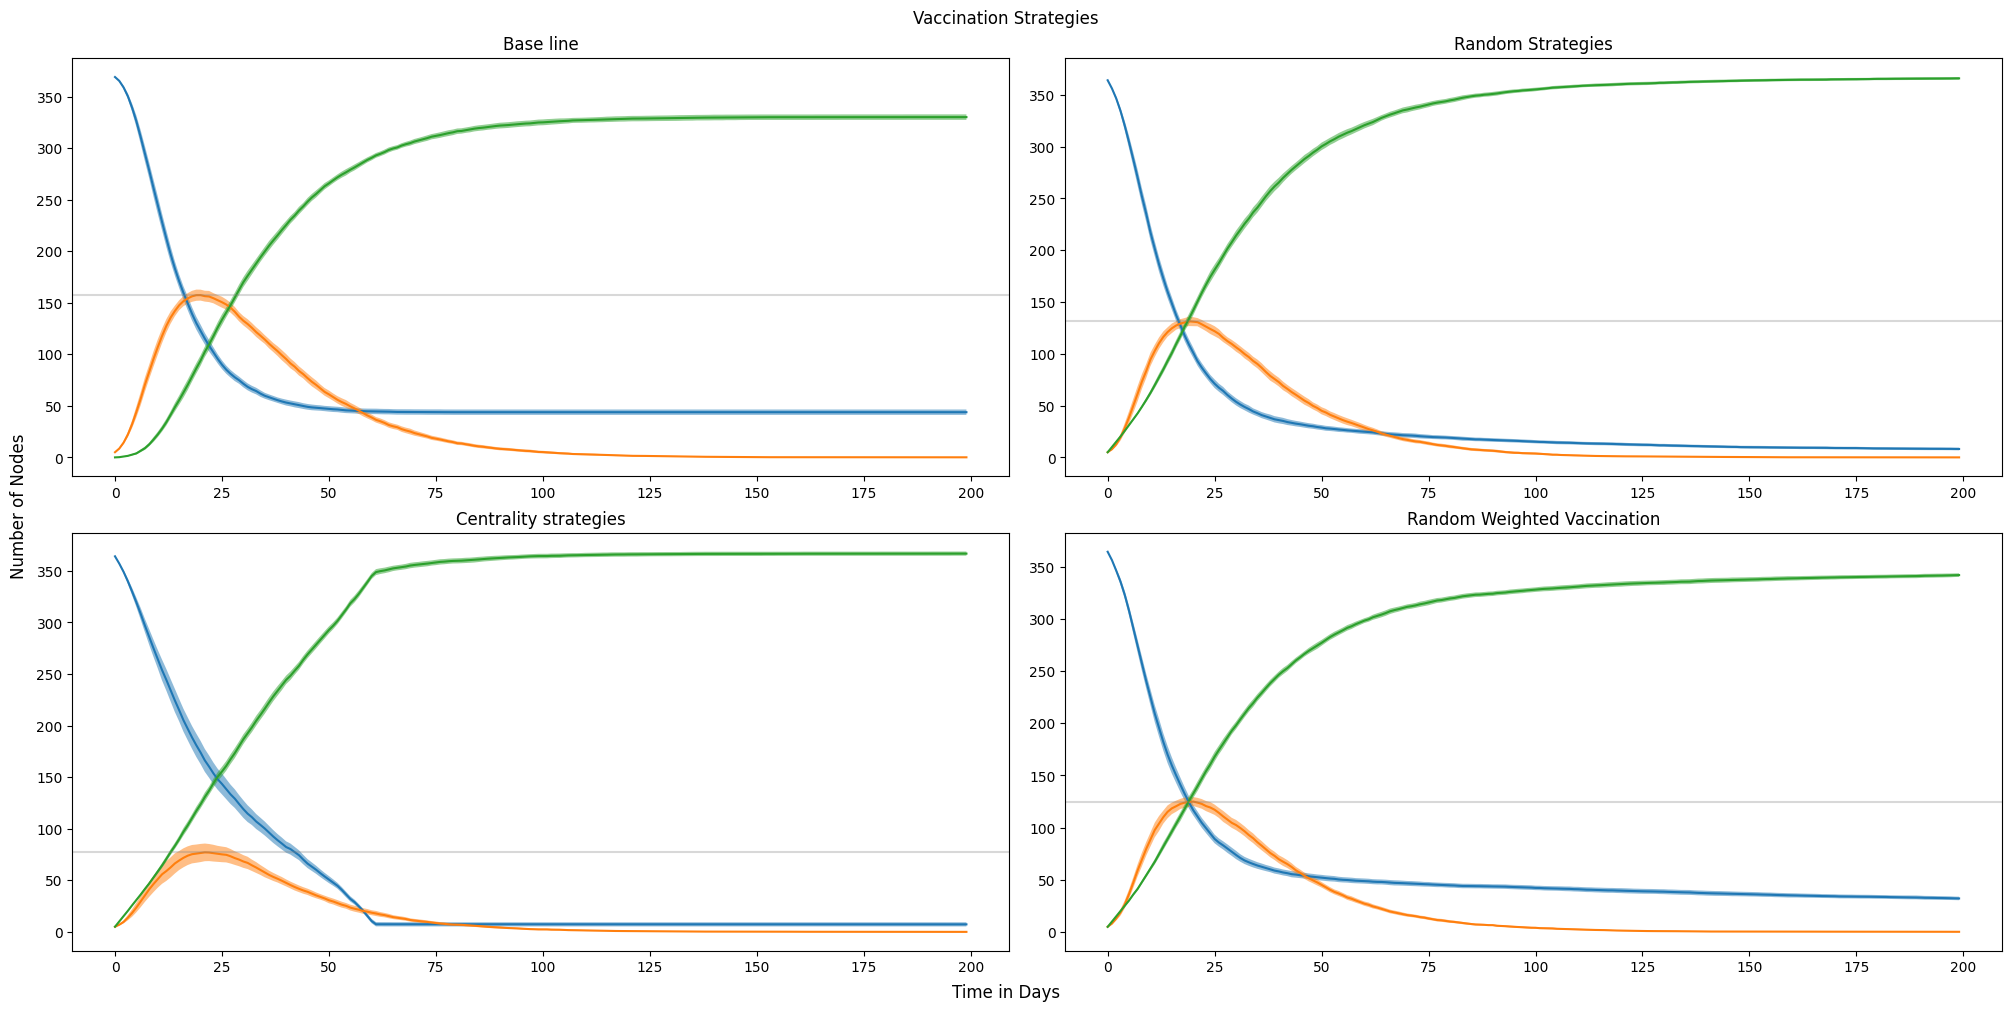

In [59]:
np.random.seed(123)
f = pd.read_csv("transmission_network.csv", header=0, index_col=0, delimiter=";")
# Removing the weights
for column in f.columns:
    f[column] = [1 if x else 0 for x in f[column]]
graph_part2 = nx.Graph(f.values)



def random_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible"]
    if available:
        simulation.vaccine_targets = np.random.choice(available, size=simulation.vaccines)
        
def random_testing(simulation, accuracy=1):
    testing = np.random.choice(simulation.graph.nodes(), size= simulation.testIter)
    for node in testing:
        actual_status = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
        test_result = np.random.choice([actual_status, "Susceptible"], size=1, p=[accuracy, 1-accuracy])[0]
        simulation.graph.nodes()[node]["check"] = test_result
        simulation.tests -= 1

def centrality_testing(simulation, accuracy=1):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]

    testing = sorted(simulation.graph.degree(), key=lambda x: x[1], reverse=True)
    testing = [node for node,_ in testing if node in available]
    for node in testing[:simulation.testIter]:
        actual_status = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
        test_result = np.random.choice([actual_status, "Susceptible"], size=1, p=[accuracy, 1-accuracy])[0]
        simulation.graph.nodes()[node]["check"] = test_result
        simulation.tests -= 1
        
## Centrality measures
def centrality_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
    
    targets = sorted(simulation.graph.degree(), key=lambda x: x[1], reverse=True)
    available_target = [node for node,_ in targets if node in available]
    simulation.vaccine_targets = available_target[:simulation.vaccines]
    
## Centrality measures
# def closeness_vaccination(simulation):
#     available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
#     while len(simulation.vaccine_targets) > simulation.vaccines:
#         initial_nodes = np.random.choice(available, size=5)
#         for j in initial_nodes:
#             neighbor = np.random.choice(simulation.graph.neighbors(j), size=1)
#             if len(simulation.vaccine_targets) > simulation.vaccines:
#                 simulation.vaccine_targets.append(neighbor)
                
# def neighbor_vaccination(simulation):
#     infecteds = [node for node in simulation.graph.nodes if simulation.graph.nodes[node]["check"] == "Infected"]
#     available = [node for node in simulation.graph.nodes if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
#     all_neighbors = {}
#     for infected in infecteds:
#         for neighbor in simulation.graph.neighbors(infected):
#             all_neighbors[neighbor] = len([*simulation.graph.neighbors(neighbor)])
#     available_target = {node:degree for node,degree in all_neighbors.items() if node in available}
#     targets = sorted(available_target.keys(), key=lambda x: available_target[x], reverse=True)
#     # print(targets)
#     simulation.vaccine_targets = targets[:simulation.vaccines]
#     if not simulation.vaccine_targets:
#         centrality_vaccination(simulation)

# def stay_aheadtesting(simulation, accuracy=1):
#     available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
#     infecteds = [node for node in simulation.graph.nodes if simulation.graph.nodes[node]["check"] == "Infected"]
#     next_target = None
#     if  not infecteds:
#         centrality_testing(simulation, accuracy) 
#         return
#         
#     if not simulation.testing_target:
#         all_infections = {x[0]:x[1] for x in simulation.graph.degree(infecteds)}
#         simulation.testing_target = max(all_infections, key=all_infections.get)
#         
#     neighbors = sorted(simulation.graph.neighbors(simulation.testing_target), key=lambda x: simulation.graph.degree(x), reverse=True)
#     testing = [node for node in neighbors if node in available][:simulation.testIter]
#     for node in testing:
#         actual_status = ["Susceptible", "Infected", "Recovered"][simulation.model.status[node]] ## Poor man's dictionary
#         test_result = np.random.choice([actual_status, "Susceptible"], size=1, p=[accuracy, 1-accuracy])[0]
#         if test_result == "Infected":
#             next_target = node
#         simulation.graph.nodes()[node]["check"] = test_result
#         simulation.tests -= 1
#         simulation.history.append(node)
#     if next_target:
#         simulation.testing_target = next_target
#     else:
#         simulation.testing_target = neighbors[0]
        
def number_of_S_neighbor(simulation, node):
    return sum([1 for x in simulation.graph.neighbors(node) if simulation.graph.nodes[x]["check"] == "Susceptible"])

# def stay_ahead_vaccination(simulation):
#     available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
#     infecteds = [node for node in simulation.graph.nodes if simulation.graph.nodes[node]["check"] == "Infected"]
#     if  not infecteds:
#         centrality_vaccination(simulation)
#         return
# 
#     if not simulation.vaccine_target:
#         all_infections = {x[0]:x[1] for x in simulation.graph.degree(infecteds)}
#         simulation.testing_target = max(all_infections, key=all_infections.get)
# 
#     neighbors = sorted(simulation.graph.neighbors(simulation.testing_target), key=lambda x: number_of_S_neighbor(simulation, x), reverse=True)
#     testing = [node for node in neighbors if node in available][:simulation.testIter]
#     for node in testing:
#         simulation.vaccine_targets.append(node)
#     simulation.vaccine_target = neighbors[0]

def random_weighted_vaccination(simulation):
    available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible"]
    if available:
        neighbors = [number_of_S_neighbor(simulation,x)for x in available]
        total = sum(neighbors)
        weights = [x/total for x in neighbors]
        simulation.vaccine_targets = np.random.choice(available, size=simulation.vaccines, p=weights)
        
# def centralSVaxx(simulation):
#     available = [node for node in simulation.graph.nodes() if simulation.graph.nodes[node]["check"] == "Susceptible" and node not in simulation.history]
# 
#     targets = sorted(simulation.graph.degree(), key=lambda x: number_of_S_neighbor(simulation, x[0]), reverse=True)
#     available_target = [node for node,_ in targets if node in available]
#     simulation.vaccine_targets = available_target[:simulation.vaccines]
#     
kwargs = {
    "graph": graph_part2,
    "iterations": 200,
    "tests": 200,
    "testIter": 10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 5,
    "beta": 1/10,
    "gamma": 1/20,
    "vaccination_strat": baseline,
    "testing_strat": baseline,  
}
runs = 30
fig,ax = plt.subplots(2,2, figsize=(20,10), layout="constrained")

ax = ax.ravel()
# 
sim = Simulation(**kwargs)

sim.setup_model()
base_data = sim.run(runs)
plot_data(base_data, ax[0], 90, "Base line", individual=False)

kwargs["vaccination_strat"] = random_vaccination
kwargs["testing_strat"] = random_testing
sim = Simulation(**kwargs)
sim.setup_model()
random_data = sim.run(runs)
plot_data(random_data, ax[1], 90, "Random Strategies", individual=False)
# 
kwargs["vaccination_strat"] = centrality_vaccination
kwargs["testing_strat"] =  centrality_testing
sim = Simulation(**kwargs)
sim.setup_model()
closeness_data = sim.run(runs)
plot_data(closeness_data, ax[2], 90, "Centrality strategies", individual=False)

kwargs["vaccination_strat"] = random_weighted_vaccination
kwargs["testing_strat"] = centrality_testing 
sim = Simulation(**kwargs)
sim.setup_model()
random_data = sim.run(runs)
plot_data(random_data, ax[3], 90, "Random Weighted Vaccination", individual=False)
fig.suptitle("Vaccination Strategies")
fig.supxlabel("Time in Days")
fig.supylabel("Number of Nodes")

fig.savefig("strategies")

64.76666666666667
73.63333333333334
72.33333333333333
76.96666666666667


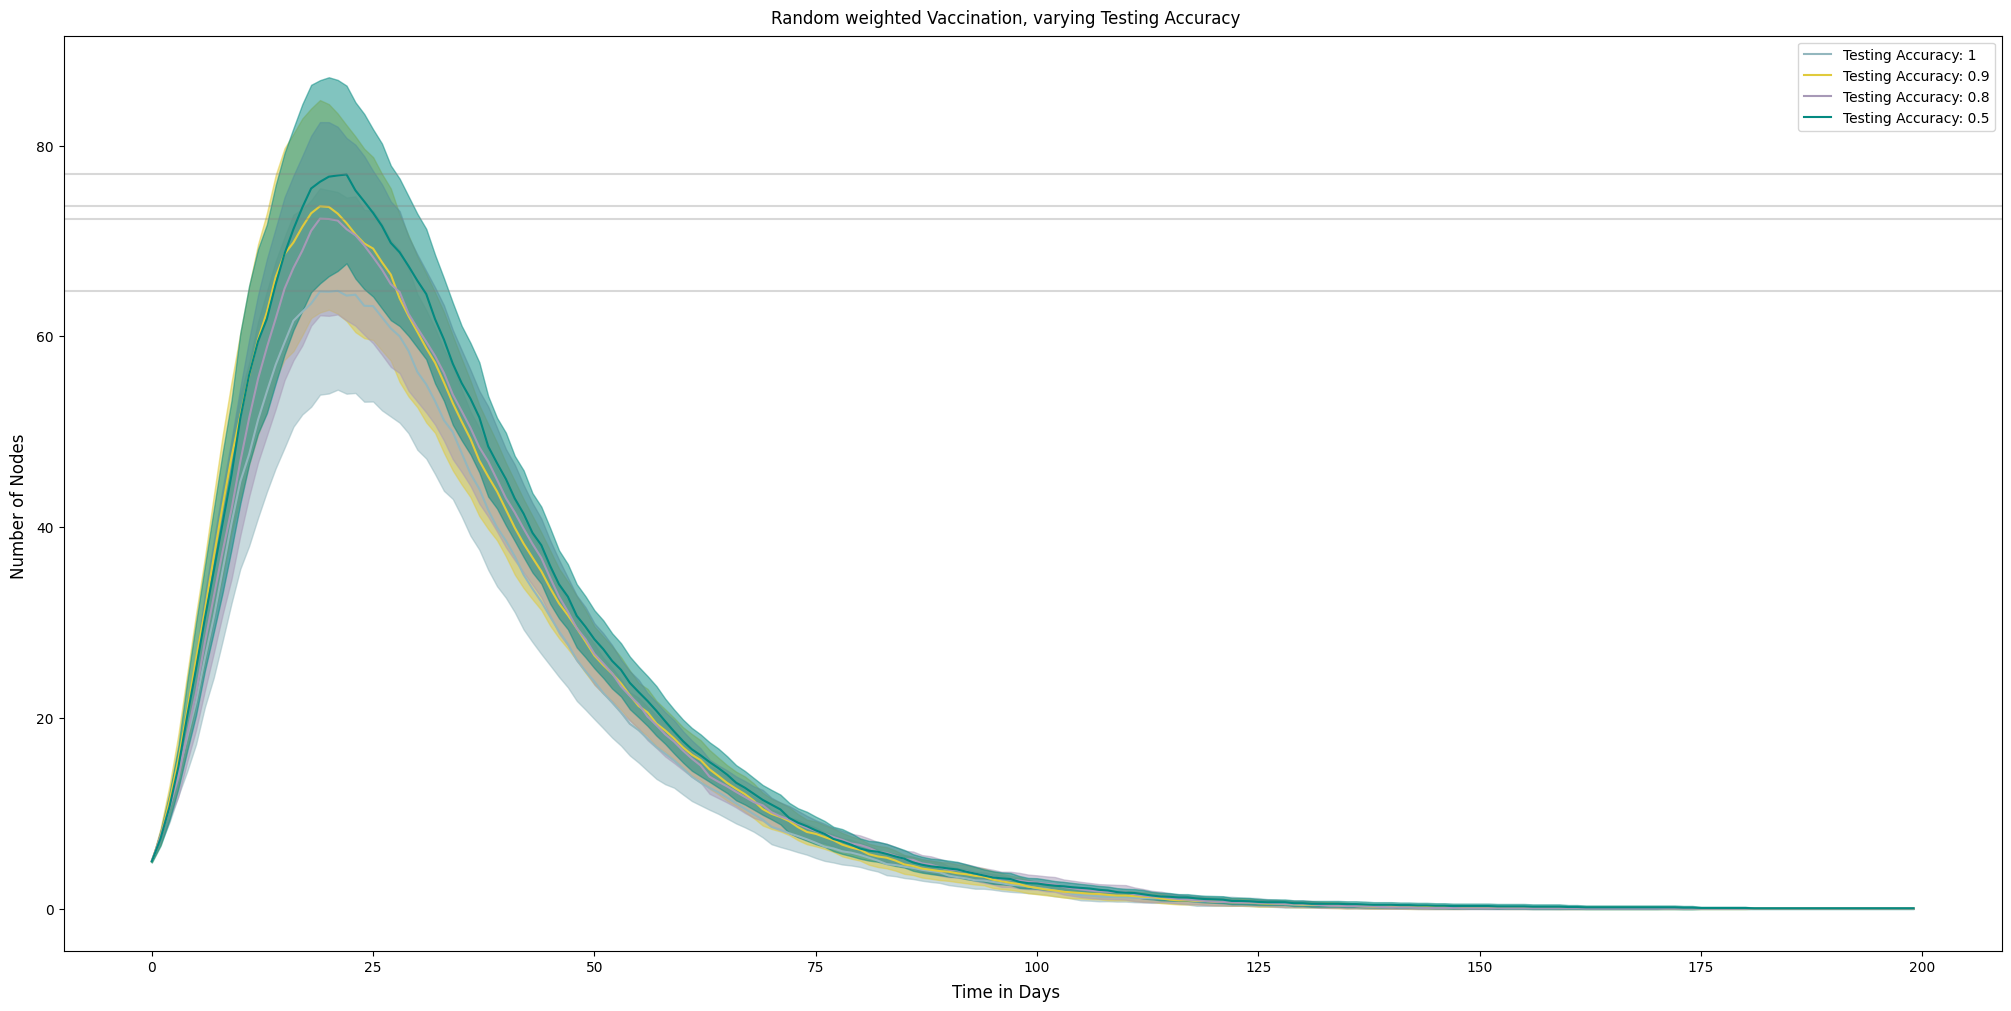

In [61]:
kwargs = {
    "graph": graph_part2,
    "iterations": 200,
    "tests": 200,
    "testIter": 10,
    "accuracy": 1,
    "vaccines": 5,
    "infected": 5,
    "beta": 1/10,
    "gamma": 1/20,
    "vaccination_strat": centrality_vaccination,
    "testing_strat": centrality_testing,
}
np.random.seed(1234)
runs=30
fig,ax = plt.subplots(1,1, figsize=(20,10), layout="constrained")

# ax = ax.ravel()
for i,accuracy in [(0,1),(1,0.9),(2,0.8),(3,.5)]:
    kwargs["accuracy"] = accuracy
    sim = Simulation(**kwargs)
    sim.setup_model()
    random_data = sim.run(runs)
     
    stackedplot_data(random_data, ax, 90, f"Testing Accuracy: {accuracy}", individual=False, color = i)
ax.legend(loc="best")
fig.suptitle("Random weighted Vaccination, varying Testing Accuracy")
fig.supxlabel("Time in Days")
fig.supylabel("Number of Infected Nodes")
fig.savefig("accuracy")


In [ ]:
kwargs = {
    "graph": graph_part2,
    "iterations": 200,
    "tests": 200,
    "testIter": 10,
    "accuracy": 1,
    "vaccines": 10,
    "infected": 5,
    "beta": 1/10,
    "gamma": 1/20,
    "vaccination_strat": centrality_vaccination,
    "testing_strat": centrality_testing,
}
np.random.seed(123)
runs = 30
fig,ax = plt.subplots(1,1, figsize=(20,10), layout="constrained")

for i,vaccines in [(0,1),(1,3),(2,5),(3,10)]:
    kwargs["vaccines"] =vaccines 
    sim = Simulation(**kwargs)
    sim.setup_model()
    random_data = sim.run(runs)

    stackedplot_data(random_data, ax, 0, f"Number of Vaccines: {vaccines}", individual=False, color=i)
ax.legend(loc="best")
fig.suptitle("Random weighted Vaccination, varying number of available Vaccines")
fig.supxlabel("Time in Days")
fig.supylabel("Number of Infetected Nodes")
fig.savefig("Vaccines")


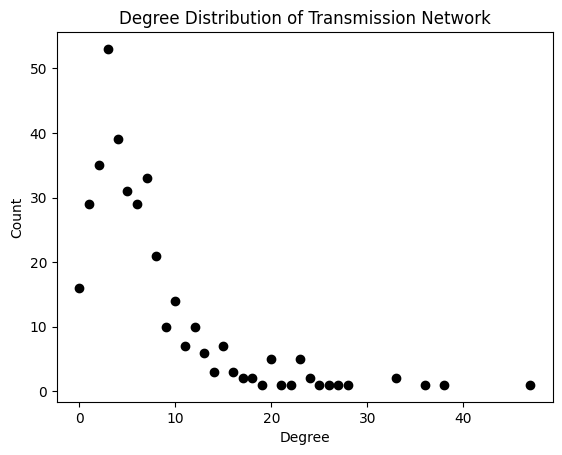

In [65]:
degrees = {}
for node,degree in graph_part2.degree:
    if degree in degrees.keys():
       degrees[degree] += 1 
    else:
        degrees[degree] = 1
        
        
plt.scatter(degrees.keys(),degrees.values(), color="black")
plt.title("Degree Distribution of Transmission Network")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.savefig("degrees")

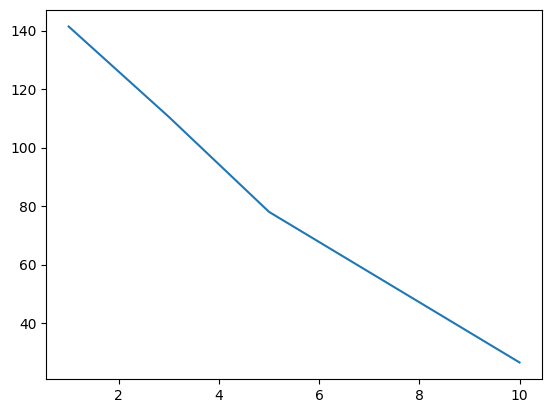

In [19]:
data = [141.4
,110.5
,78.03333333333333
,26.566666666666666]
plt.plot([1,3,5,10],data)
